# WiDS Datathon Workshop 2024

<img src="logos.png" style="height: 200px;" align="center"/>

**Organizers:** Sharut Gupta (MIT CSAIL), Jia He (Microsoft), and Arushi Jain (Microsoft).

**Datathon:** https://www.kaggle.com/competitions/widsdatathon2024-challenge2/

**Datathon task:** predicting the duration of time it takes for patients to receive metastatic cancer diagnosis.

## Learning Goals:
* Understand basic concepts of Machine Learning
* Train a deep neural network for the regression task
* Interpretability analysis to understand the importance of each feature

In [ ]:
# Import all libraries and install using the following command if needed
# !pip install category_encoders
!pip install shap
!pip install lightgbm
!pip install category_encoders
import shap
import numpy as np
import pandas as pd
import torch
import joblib
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
import re
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load the datasets by reading CSV Files
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')
print(f'Number of features in train dataset are {train_raw.shape[1]}')

Number of features in train dataset are 152


In [ ]:
# Assuming train_processed.csv and y_train.csv are loaded and ready to use
train_processed = pd.read_csv('train_processed.csv')
y_train = pd.read_csv('y_train.csv')
test_processed = pd.read_csv('test_processed.csv')
print(f'Number of features in Processed train dataset are {train_processed.shape[1]}')

# Convert DataFrame to tensor
X_train_tensor = torch.tensor(train_processed.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.squeeze(), dtype=torch.float32)  # Ensure y_train is the correct shape

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.2, random_state=42)

# Create TensorDatasets and DataLoader for training
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

feature_names = train_processed.columns.tolist()
print(f'Feature names are {feature_names}')

Number of features in Processed train dataset are 149
Feature names are ['patient_id', 'patient_race', 'payer_type', 'patient_state', 'patient_zip3', 'Region', 'Division', 'patient_age', 'bmi', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married', 'widowed', 'family_size', 'family_dual_income', 'income_household_median', 'income_household_under_5', 'income_household_5_to_10', 'income_household_10_to_15', 'income_household_15_to_20', 'income_household_20_to_25', 'income_household_25_to_35', 'income_household_35_to_50', 'income_household_50_to_75', 'income_household_75_to_100', 'income_household_100_to_150', 'income_household_150_over', 'income_household_six_figure', 'income_individual_median', 'home_

## Deep Neural Network (DNN) Overview
---
A Deep Neural Network (DNN) is a type of artificial neural network with multiple layers between the input and output layers. Each layer in a DNN typically consists of a set of neurons (nodes) that process input data and pass it to the next layer. DNNs are capable of learning complex patterns and representations from data, making them powerful tools for tasks such as image and speech recognition, natural language processing, and many others.

<img src="dnn.png" style="width: 400px;" align="center"/>

- **Input Layer**: This is where data enters the network. Each unit in this layer represents one feature of the input data.
- **Hidden Layers**: These are the layers between the input and output layers. Each hidden layer typically consists of a number of neurons or nodes, and each node combines input from the previous layer with a set of weights, applies an activation function, and passes the result to the next layer. The depth of a neural network is defined by the number of hidden layers it contains. More layers allow the network to capture more complex patterns.
- **Activation functions**: Activation functions are crucial to introducing non-linear properties to the network—a property that allows DNNs to learn more complex patterns. Without non-linearity, no matter how many layers the network has, it would still behave like a single-layer network. Common activation functions include: ReLU (Rectified Linear Unit), Sigmoid, Tanh (Hyperbolic Tangent). 
- **Output Layer**: The final layer produces the output of the model. The structure of this layer depends on the specific task (e.g., a single neuron for binary classification or multiple neurons for multi-class classification).

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        # Layer 1: Linear transformation from the number of features in train_processed to 64 neurons
        self.layer1 = nn.Linear(train_processed.shape[1], 64)
        # Batch normalization for the first hidden layer
        self.bn1 = nn.BatchNorm1d(64)
        # Dropout to prevent overfitting; 50% of the neurons are zeroed out randomly during training
        self.dropout1 = nn.Dropout(0.5)
        self.layer2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        # Apply ReLU activation function after batch normalization to the output of the first layer
        x = F.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.layer2(x)))
        # Output layer does not have activation; this depends on the loss function used later (e.g., for binary classification, you might add a sigmoid activation here)
        x = self.output_layer(x)
        return x



In [ ]:
# Instantiate the model and hyperparameters
model = NeuralNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
best_val_loss = float('inf')


# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Iterate over batches of the training data
    for batch_idx, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad() # Reset the gradients to zero for starting backpropagation
        outputs = model(data) # Forward pass through the model to get the outputs
        loss = criterion(outputs, targets.view(-1, 1)) # Compute the loss between outputs and the targets
        loss.backward() # Backward pass to compute the gradient of the loss with respect to model parameters
        optimizer.step() # Update the model parameters based on the optimizer
        running_loss += loss.item()
    scheduler.step() # Step the scheduler to adjust the learning rate

    # Evaluate the model with the validation data
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, targets in val_loader:
            outputs = model(data)
            val_loss += criterion(outputs, targets.view(-1, 1)).item()
    val_loss /= len(val_loader)

    # Check if the current validation loss is the best and save the model if so
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Val Loss: {val_loss}')



Epoch 1/50, Loss: 19205.24609375, Val Loss: 21591.73411923363
Epoch 6/50, Loss: 19009.958984375, Val Loss: 13301.709251767114
Epoch 11/50, Loss: 7245.18603515625, Val Loss: 7717.226225353423
Epoch 16/50, Loss: 10697.0068359375, Val Loss: 7424.66693405878
Epoch 21/50, Loss: 5711.2958984375, Val Loss: 7348.610444568452
Epoch 26/50, Loss: 5218.20654296875, Val Loss: 7205.8158947172615
Epoch 31/50, Loss: 9733.6220703125, Val Loss: 7222.296979631697
Epoch 36/50, Loss: 5485.87890625, Val Loss: 7111.38775344122
Epoch 41/50, Loss: 8439.7685546875, Val Loss: 7317.493745349702
Epoch 46/50, Loss: 13349.6474609375, Val Loss: 7294.660074869792


## Effect of `model.eval()` in PyTorch

In PyTorch, `model.eval()` is used to set the model into evaluation mode. This mode is particularly important when you have specific layers in your model that should behave differently during training and testing phases.

### Effects of `model.eval()`

1. **Disables Dropout Layers**: In training mode, dropout layers randomly drop units in the input tensor to prevent the network from becoming too reliant on any single neuron and to improve generalization. However, during testing or inference, you want your model to leverage the full capacity of its trained network. Calling `model.eval()` ensures that dropout layers will pass their inputs to the next layer unchanged.

2. **Disables Batch Normalization Layers**: During training, batch normalization layers normalize their input using the mean and variance of the current batch. This helps to stabilize the learning process. However, during evaluation, you want to normalize the input using the entire dataset's more stable mean and variance, not just the current batch. `model.eval()` switches the batch normalization layer to use the entire dataset's mean and variance, which were estimated during training.


In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Context-manager that disables gradient calculation
    predictions_train = model(X_train)
    predictions_val = model(X_val)
    rmse_train = torch.sqrt(criterion(predictions_train, y_train.unsqueeze(1))).item()
    rmse_val = torch.sqrt(criterion(predictions_val, y_val.unsqueeze(1))).item()
print(f"Training RMSE: {rmse_train} Validation RMSE: {rmse_val}")


Training RMSE: 85.53250122070312 Validation RMSE: 85.61749267578125


## Interpretability Analysis
---
### Shapley Additive Explanations
SHAP (SHapley Additive exPlanations) utilizes game theory to explain individual predictions of machine learning models, revealing how each feature influences a specific prediction. This method quantifies the contribution of each feature to the difference between the actual prediction and the dataset's average prediction.

### Gradient Explainer
GradientExplainer is a SHAP explainer specifically designed for differentiable models like neural networks. It uses model gradients to efficiently estimate SHAP values, which indicate how features contribute to predictions. This explainer is especially useful for its computational efficiency in deep learning contexts.

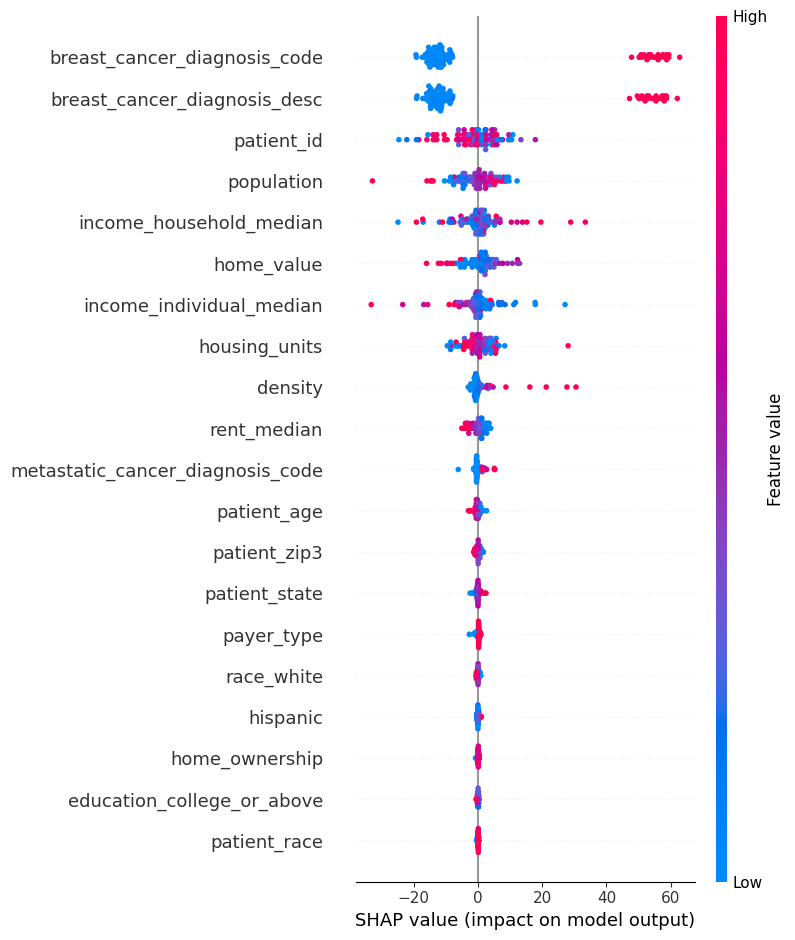

In [ ]:
# Select a small subset of your data as a background distribution.
# Background data is used to integrate out features by averaging over them.
# Only a small subset is typically necessary and should be representative of the whole dataset.
background_data = X_train[:100]  # Use the first 100 samples to approximate the background distribution
test_data = X_train[101:200]
model.eval()


# Create and fit a GradientExplainer
explainer = shap.GradientExplainer(model, background_data)
shap_values = explainer.shap_values(test_data, nsamples=200)  # Adjust nsamples based on computational feasibility
shap.summary_plot(np.squeeze(shap_values, axis=2), feature_names=feature_names, plot_type='dot', features=test_data)


## Understanding K-Fold Cross-Validation in Deep Learning
---

K-Fold cross-validation is a robust statistical technique used to evaluate and validate models by dividing the data into k subsets (or folds). Here's how it benefits deep learning model training:

* Reduced Overfitting: By rotating the training and validation sets, each data point gets to be in a validation set exactly once and in a training set k-1 times. This method ensures that the model is tested on all available data, reducing the chances of overfitting.
* Reliable Model Evaluation: K-Fold increases the reliability of the model evaluation process by averaging the model's performance across different subsets. This approach helps in mitigating the variance associated with the random selection of the train-test split, leading to a more generalizable model.
* Model Robustness: Repeated training and validation help in identifying the best and most stable model configuration, as parameters can be fine-tuned to optimize performance across all folds.

In practice, for tasks like training a neural network, K-Fold cross-validation can be particularly useful for datasets that are not overwhelmingly large, as it maximizes the use of available data for training.

<img src="kfold_rotation.png" style="width: 600px;" align="center"/>


In [ ]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Prepare full dataset
full_dataset = TensorDataset(X_train_tensor, y_train_tensor)

results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor)):
    # Create data samplers for training and validation using indices
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    # Define data loaders for training and validation
    train_loader = DataLoader(full_dataset, batch_size=64, sampler=train_subsampler)
    val_loader = DataLoader(full_dataset, batch_size=64, sampler=val_subsampler)
    
    # Initialize a fresh model and optimizer each fold
    model = NeuralNet()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    best_val_loss = float('inf')
    criterion = nn.MSELoss()
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for data, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets.view(-1, 1))
            loss.backward()
            optimizer.step()
        scheduler.step()

        # Validate after each epoch
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, targets in val_loader:
                outputs = model(data)
                val_loss += criterion(outputs, targets.view(-1, 1)).item()

        val_loss /= len(val_loader)

        # Track the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save the best model if required

    results.append(best_val_loss)
    print(f'Fold {fold+1}, Best Validation Loss: {best_val_loss}')

print(f'Average K-Fold Validation Loss: {np.mean(results)}')


Fold 1, Best Validation Loss: 7061.8888927641365
Fold 2, Best Validation Loss: 7363.023664202009
Fold 3, Best Validation Loss: 6844.357058570498
Fold 4, Best Validation Loss: 7020.1501057942705
Fold 5, Best Validation Loss: 6991.8341064453125
Average K-Fold Validation Loss: 7056.2507655552445


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7fac8949-e1e6-4930-a299-37efc86d9a40' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>